In [1]:
import pandas as pd
from glob import glob
import seaborn as sns
import numpy as np

In [2]:
def fasta_dict(fasta):
    with open(fasta,'r') as f:
        lines = f.readlines()

        seqs = {}
        for l in range(0,len(lines),2):
            
            name = lines[l].replace('>','').replace('\n','')
            seq = lines[l+1].replace('\n','')
            
            seqs[name] = seq
        
    return seqs

In [3]:
score_df = []
for fasta in glob('<path/to/your>/MPNN_outputs/seqs/*.fa'):
    seq_dict = fasta_dict(fasta)
    orig_name = fasta.split('/')[-1].replace('.fa','')
    
    for i,name in enumerate(seq_dict):
        
        if orig_name not in name:
            score_df.append([f'{orig_name}_{i}', float(name.split(', ')[2].replace('score=','')), seq_dict[name]])
            
score_df = pd.DataFrame(score_df,columns=['name','score','sequence'])
score_df['length'] = score_df['sequence'].map(lambda x: len(x))

In [4]:
print(len(score_df))
score_df = score_df.drop_duplicates('sequence')
score_df.index = list(range(len(score_df)))
print(len(score_df))

36208
36088


In [5]:
inpainting_scores = pd.read_csv('<path/to/your>/inpainting_scores.csv',index_col=0) #from make_MPNN_commands.ipynb
score_df['base_name'] = score_df['name'].map(lambda x: '_'.join(x.split('_')[:-1]))
score_df = score_df.merge(inpainting_scores,left_on='base_name',right_on='name',how='left')

score_df['name'] = score_df['name_x']
del score_df['name_x']
del score_df['name_y']

score_df['has_cys'] = score_df['sequence'].map(lambda x: 'C' in x[:-179])

print(len(score_df))

36088


In [6]:
score_df.head()

,score,sequence,length,base_name,pLDDT_full,pLDDT_inpaint,linker_start,linker_end,name,has_cys
0,1.2185,MKEDVLRLLESARWHMAQGGGLYNARVLVEEAARLAATLTGPEAEA...,251,hit6_reloop_1427_0,0.838609,0.706821,59,72,hit6_reloop_1427_0_1,False
1,1.2683,AAADVRRLLASAEWLLAAGGGLRNAAALVDEAAALAATLTGPEAAA...,251,hit6_reloop_1427_0,0.838609,0.706821,59,72,hit6_reloop_1427_0_2,False
2,1.2359,MAEDVERLIASAEWWLAAGGGLRNARVLLDLAAEEAATLTGPEAEE...,251,hit6_reloop_1427_0,0.838609,0.706821,59,72,hit6_reloop_1427_0_3,False
3,1.2391,MAEDVRRLIASARWLMAQGGGLRGARYLLELARELARTLTGPEAEE...,251,hit6_reloop_1427_0,0.838609,0.706821,59,72,hit6_reloop_1427_0_4,False
4,0.9860,MREDVERLLRSARWHIEQGGGLYNARVLVEEARRLAETLSGPEAEE...,251,hit6_reloop_1427_0,0.838609,0.706821,59,72,hit6_reloop_1427_0_5,False


In [7]:
score_df.to_csv('<desired/path/to>/MPNN_scores.csv')

In [8]:
np.sum(score_df['has_cys'])

0

<AxesSubplot:xlabel='length', ylabel='Count'>

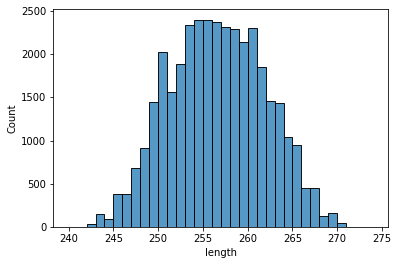

In [9]:
sns.histplot(score_df['length'],bins=list(range(240,275)))

<AxesSubplot:xlabel='score', ylabel='Count'>

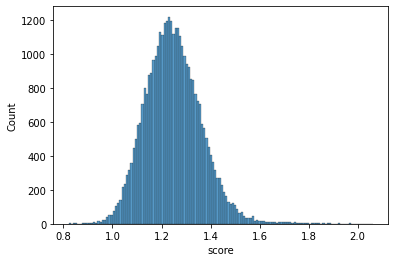

In [10]:
sns.histplot(score_df['score'])

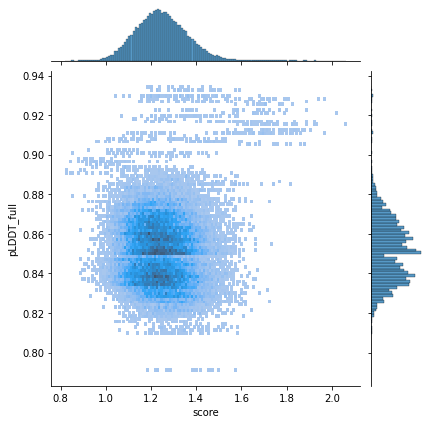

In [11]:
sns.jointplot(data=score_df,x='score',y='pLDDT_full',kind='hist')

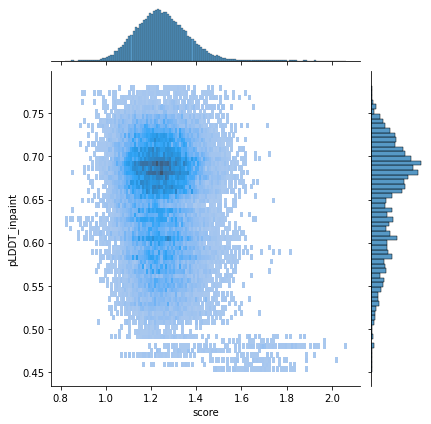

In [12]:
sns.jointplot(data=score_df,x='score',y='pLDDT_inpaint',kind='hist')

In [15]:
for length, group in score_df.groupby('length'):
    group.index = list(range(len(group)))
    
    for i in range(0,len(group),100):
        with open(f'<desired/path/to>/MPNN_outputs/for_AF2/{length}_{i//100}.fasta','w') as f:
            for ii in range(i,min(i+100,len(group))):
                name = group.loc[ii,'name']
                seq = group.loc[ii,'sequence']
                f.write(f'>{name}\n{seq}\n')

In [16]:
with open('<desired/path/to>/AF2_cmds.list','w') as f:
    for in_fasta in glob('<desired/path/to>/MPNN_outputs/for_AF2/*.fasta'):
        name = in_fasta.split('/')[-1].replace('.fasta','')
        linker_len = int(name.split('_')[0])
        template = '<path/to/your>/CSM8_af2pred.pdb' #your AF2-predicted design model
            
        f.write('python <path/to/your>/03_linker/masked_template_AF2_monomer_pred.py '+\
                f'-fasta {in_fasta} -template_pdb {template} -exclude_template 1-57 '+\
                f'-outname <desired/path/to>/AF2_outputs/{name} -interface1 1-57 -interface2 {linker_len+57}-{linker_len+57+179}\n')